# Tools

In [1]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings

In [2]:
loader = DirectoryLoader('../dataset/llamaindex_data', glob="*", show_progress=True)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
  separators=["\n\n", "\n", " "],
  chunk_size=1024,
  chunk_overlap=20,
  length_function=len,
  is_separator_regex=False,
)

documents = text_splitter.split_documents(docs)

embed_model = OpenAIEmbeddings(
  model="text-embedding-3-small",
)

vector_index = FAISS.from_documents(documents, embed_model)

retriever = vector_index.as_retriever(search_type="mmr")

100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


In [3]:
vector_index.save_local("../models/faiss_chatgpt.json")

In [4]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
  retriever,
  "retriever-llm",
  description="You should use this tool for queries related to machine learning. A function for searching documents related to LLM or ML"
)



In [5]:
retriever_tool.run("What is TD learning?")

"==== Dactyl ==== Developed in 2018, Dactyl uses machine learning to train a Shadow Hand, a human-like robot hand, to manipulate physical objects. It learns entirely in simulation using the same RL algorithms and training code as OpenAI Five. OpenAI tackled the object orientation problem by using domain randomization, a simulation approach which exposes the learner to a variety of experiences rather than trying to fit to reality. The set-up for Dactyl, aside from having motion tracking cameras, also has RGB cameras to allow the robot to manipulate an arbitrary object by seeing it. In 2018, OpenAI showed that the system was able to manipulate a cube and an octagonal prism. In 2019, OpenAI demonstrated that Dactyl could solve a Rubik's Cube. The robot was able to solve the puzzle 60% of the time. Objects like the Rubik's Cube introduce complex physics that is harder to model. OpenAI did this by improving the robustness of Dactyl to perturbations by using Automatic Domain Randomization (A

In [6]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=100)
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [7]:
wikipedia_tool.name

'wikipedia'

In [8]:
wikipedia_tool.description

'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.'

In [9]:
wikipedia_tool.run("What is UX?")

'Page: User experience design\nSummary: User experience design (UX design, UXD, UED, or XD), upon whic'

In [10]:
import re
import seaborn as sns

from langchain.tools import tool

@tool
def graph_generator(text):
  """
  Use this function when you need to generate a graph.
  input format should be label1|number1,label2|number2
  """

  label, data = list((zip(*re.findall("([^\|,\"]+) *\| *([\d]+)", text))))
  data = list(map(lambda x: int(x), data))

  sns.barplot(x=label, y=data)

  return "I have generated graph for you!"

'I have generated graph for you!'

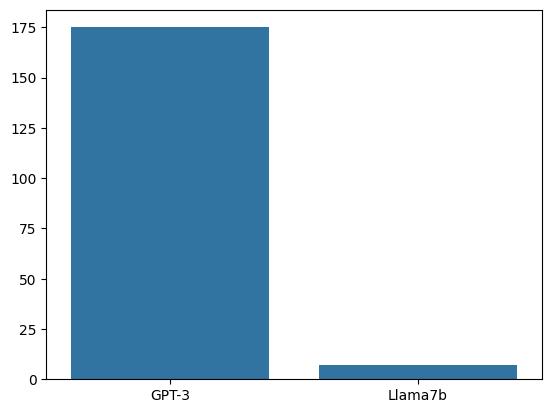

In [11]:
graph_generator.invoke("GPT-3|175,Llama7b|7")

In [12]:
tools = [retriever_tool, graph_generator]

# Agent

In [13]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

In [14]:
from langchain import hub

prompt = hub.pull("hwchase17/openai-functions-agent")
prompt

/Users/hyeonjinho/.pyenv/versions/3.11.6/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='

In [15]:
from langchain.agents import create_openai_functions_agent, AgentExecutor

agent = create_openai_functions_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [16]:
agent_executor.invoke({"input": "hi!"})



> Entering new AgentExecutor chain...
Hello! How can I assist you today?

> Finished chain.


{'input': 'hi!', 'output': 'Hello! How can I assist you today?'}

In [17]:
agent_executor.invoke({"input": "What is Mistral AI?"})



> Entering new AgentExecutor chain...

Invoking: `retriever-llm` with `{'query': 'What is Mistral AI?'}`


25. 3. 1. 오후 11:31

Mistral AI

Mistral AI SAS is a French artificial intelligence (AI) startup, headquartered in Paris. It specializes in open-weight large language models (LLMs).[2][3]

Namesake

The company is named after the mistral, a powerful, cold wind in southern France.[4]

History

Mistral AI was established in April 2023 by three French AI researchers, Arthur Mensch, Guillaume Lample and Timothée Lacroix.[5]

Mensch, an expert in advanced AI systems, is a former employee of Google DeepMind; Lample and Lacroix, meanwhile, are large-scale AI models specialists who had worked for Meta Platforms.[6]

The trio originally met during their studies at École Polytechnique.[4]

Company operation

Philosophy

Mistral AI emphasizes openness and innovation in the AI field and positions itself as an alternative to proprietary models.[7]

The company has gained prominence as an alte

{'input': 'What is Mistral AI?',
 'output': 'Mistral AI is a French artificial intelligence startup based in Paris. It specializes in open-weight large language models (LLMs). The company was founded in April 2023 by three French AI researchers: Arthur Mensch, Guillaume Lample, and Timothée Lacroix. Mistral AI emphasizes openness and innovation in the AI field, positioning itself as an alternative to proprietary models. The company has raised significant funding, with the latest funding round in June 2024 elevating its valuation to €5.8 billion ($6.2 billion).'}

In [18]:
query = """
Retrieve the number of parameters of GPT-3, LLaMa(largest), LlaMa2(largest) and output them in the following format
model|number
"""

agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `retriever-llm` with `{'query': 'Number of parameters in GPT-3, LLaMa(largest), LlaMa2(largest)'}`


Mistral 7B

Mistral AI claimed in the Mistral 7B release blog post that the model outperforms LLaMA 2 13B on all benchmarks tested, and is on par with LLaMA 34B on many benchmarks tested,[41] despite having only 7 billion parameters, a small size compared to its competitors.

Mixtral 8x7B

Mistral AI's testing in 2023 shows the model beats both LLaMA 70B, and GPT-3.5 in most benchmarks.[42]

In March 2024, a research conducted by Patronus AI comparing performance of LLMs on a 100- question test with prompts to generate text from books protected under U.S. copyright law found that Open AI's GPT-4, Mixtral, Meta AI's LLaMA-2, and Anthropic's Claude 2 generated copyrighted text verbatim in 44%, 22%, 10%, and 8% of responses respectively.[43][44]

Mistral Large 2

According to Mistral AI, Large 2's performance in benchmarks is competitive w

{'input': '\nRetrieve the number of parameters of GPT-3, LLaMa(largest), LlaMa2(largest) and output them in the following format\nmodel|number\n',
 'output': 'Here are the number of parameters for the requested models:\n\n- GPT-3: 175 billion parameters\n- LLaMa (largest): Not available\n- LLaMa2 (largest): Not available'}



> Entering new AgentExecutor chain...

Invoking: `graph_generator` with `{'text': 'GPT-3|175,LlaMa(largest)|405,LlaMa2(largest)|70'}`


I have generated graph for you!I have generated the bar graph for the data you provided.

> Finished chain.


{'input': '\nGiven this data, draw a bar graph\n\nGPT-3|175 billion, LLaMa(largest)|405 billion, LlaMa2(largest)|70 billion\n\n',
 'output': 'I have generated the bar graph for the data you provided.'}

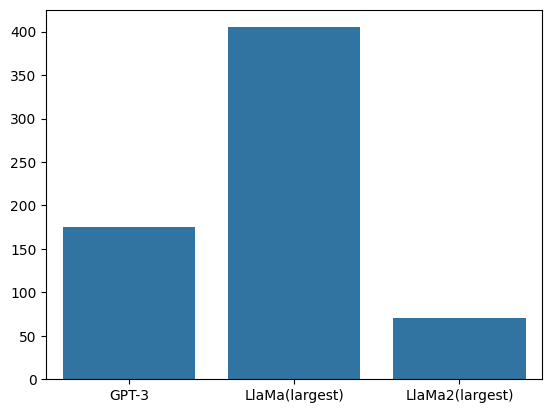

In [19]:
query = """
Given this data, draw a bar graph

GPT-3|175 billion, LLaMa(largest)|405 billion, LlaMa2(largest)|70 billion

"""

agent_executor.invoke({"input": query})

# LangGraph

In [20]:
from langgraph.graph import END, MessageGraph

graph = MessageGraph()

In [21]:
graph.add_node("oracle", llm)
graph.add_edge("oracle", END)

graph.set_entry_point("oracle")

runnable = graph.compile()

In [22]:
from langchain_core.messages import HumanMessage

runnable.invoke(HumanMessage("What is Mistral AI?"))

[HumanMessage(content='What is Mistral AI?', additional_kwargs={}, response_metadata={}, id='fbabf22a-991e-49d7-9ef5-a796b9b01f0f'),
 AIMessage(content='Mistral AI is a British company that specializes in developing artificial intelligence solutions for various industries, including automotive, healthcare, and fintech. They provide AI technology and services to help businesses improve their operations, customer experience, and decision-making processes. Their solutions include machine learning models, natural language processing, computer vision, and predictive analytics.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 13, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_rea

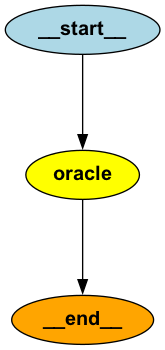

In [26]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [27]:
from langchain_core.utils.function_calling import convert_to_openai_tool

openai_tools = [convert_to_openai_tool(tool) for tool in tools]

model_with_tools = llm.bind(tools=openai_tools)

In [28]:
def invoke_model(state):
  return model_with_tools.invoke(state)

In [29]:
graph = MessageGraph()
graph.add_node("oracle", invoke_model)
graph.add_edge("oracle", END)

graph.set_entry_point("oracle")

runnable = graph.compile()



In [30]:
prompt = "hi"

runnable.invoke(HumanMessage(prompt))

[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='899b7b01-586e-4ab9-9e1c-7cbbbe867d8c'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 118, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-ed6b410f-f656-4d1a-a672-70939ad2cb0e-0', usage_metadata={'input_tokens': 118, 'output_tokens': 11, 'total_tokens': 129, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [31]:
prompt = "Retrieve the number of parameters for GPT-3, LLaMa(largest) and draw a graph"

runnable.invoke(HumanMessage(prompt))

[HumanMessage(content='Retrieve the number of parameters for GPT-3, LLaMa(largest) and draw a graph', additional_kwargs={}, response_metadata={}, id='d7bffe25-f165-44a5-b9b3-3f0ccf85b360'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w7tutXo8j1rHp2zxKAUU3Erk', 'function': {'arguments': '{"query": "Number of parameters in GPT-3"}', 'name': 'retriever-llm'}, 'type': 'function'}, {'id': 'call_oyF3WS20zGOAbv1ymUj3tdio', 'function': {'arguments': '{"query": "Number of parameters in LLaMA (largest)"}', 'name': 'retriever-llm'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 138, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'l

In [32]:
import json

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool
from typing import List
from langchain_core.messages.base import BaseMessage

In [33]:
def router(state):
  tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
  print(tool_calls)
  if tool_calls:
    print("route to use_tool")
    return "use_tool"
  else:
    print("route to end")
    return "end"

In [43]:
tool_dict = {
  "retriever-llm": retriever_tool,
  "graph_generator": graph_generator
}

In [44]:
def use_tools(state):
  print("use_tool")
  tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
  response = []

  for tool_call in tool_calls:
    function = tool_dict[tool_call['function']['name']]
    args = tool_call['function']['arguments']

    result = function.invoke(args)

    response.append(ToolMessage(
      tool_call_id=tool_call['id'],
      content=result,
      name=tool_call['function']['name'],
    ))
  
  return response

In [38]:
graph = MessageGraph()

graph.add_node("oracle", invoke_model)
graph.add_node("use_tool", use_tools)

graph.add_conditional_edges("oracle", router, {
  "use_tool": "use_tool",
  "end": END
})

graph.add_edge("use_tool", "oracle")

graph.set_entry_point("oracle")

graph.set_entry_point("oracle")



In [39]:
runnable = graph.compile()

In [40]:
prompt = "hi"

runnable.invoke(HumanMessage(prompt))

[]
route to end


[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='097cfcad-7318-45d5-ac34-88557f297250'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 118, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-f12ba7da-d34b-4d9d-ae67-4d8cf9155674-0', usage_metadata={'input_tokens': 118, 'output_tokens': 11, 'total_tokens': 129, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [41]:
prompt = "What is the number of parameters of GPT-3?"

runnable.invoke(HumanMessage(prompt))

[{'id': 'call_VWHm1FPHMT49SCsOk9JZMVnj', 'function': {'arguments': '{"query":"Number of parameters of GPT-3"}', 'name': 'retriever-llm'}, 'type': 'function'}]
route to use_tool
use_tool
[]
route to end


[HumanMessage(content='What is the number of parameters of GPT-3?', additional_kwargs={}, response_metadata={}, id='2a727b78-de80-468a-9c0e-8a5feeeffb33'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VWHm1FPHMT49SCsOk9JZMVnj', 'function': {'arguments': '{"query":"Number of parameters of GPT-3"}', 'name': 'retriever-llm'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 129, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-aee0870a-26e7-44bc-aeeb-2cdfaa30b640-0', tool_calls=[{'name': 'retriever-llm', 'args': {'query': 'Number of parameters of GPT-3'}, 'id': 'call_VWHm1FPHMT49SCsOk9JZMVnj', 'type': '

[{'id': 'call_JgTGhZmXkkZgJo8F7SO2NRjD', 'function': {'arguments': '{"text":"GPT-3|175,LLaMa|65,LLaMa2|70"}', 'name': 'graph_generator'}, 'type': 'function'}]
route to use_tool
use_tool
[]
route to end


[HumanMessage(content='\n\nGiven this data, draw a line graph\n\n|------------|--------------|\n|GPT-3|175 billion parameters|\n|LLaMa|65 billion parameters|\n|LLaMa2|70 billion parameters|\n', additional_kwargs={}, response_metadata={}, id='dfe4800a-4071-41c7-8d0a-ecee6ba98133'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JgTGhZmXkkZgJo8F7SO2NRjD', 'function': {'arguments': '{"text":"GPT-3|175,LLaMa|65,LLaMa2|70"}', 'name': 'graph_generator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 161, 'total_tokens': 194, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-492698a5-c0ac-400c-8b48-02db7ed0371d-0', tool_calls=[

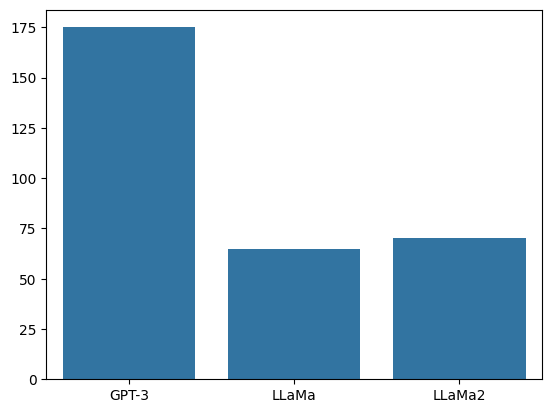

In [45]:
prompt = """

Given this data, draw a line graph

|------------|--------------|
|GPT-3|175 billion parameters|
|LLaMa|65 billion parameters|
|LLaMa2|70 billion parameters|
"""

runnable.invoke(HumanMessage(prompt))

[{'id': 'call_DMe2Xs0XSSBxwWIeyjqDXegO', 'function': {'arguments': '{"query": "Number of parameters in GPT-3"}', 'name': 'retriever-llm'}, 'type': 'function'}, {'id': 'call_SasCYOZiEmqoYUjVMh7iy9Hy', 'function': {'arguments': '{"query": "Number of parameters in LLaMA (Largest Language Model)"}', 'name': 'retriever-llm'}, 'type': 'function'}]
route to use_tool
use_tool
[{'id': 'call_QSX89UTt5wxHtAZftQ3KVILx', 'function': {'arguments': '{"text":"GPT-3|175, LLaMA|7"}', 'name': 'graph_generator'}, 'type': 'function'}]
route to use_tool
use_tool
[]
route to end


[HumanMessage(content='Retrieve the number of parameters for GPT-3, LLaMa(largest) and draw a graph', additional_kwargs={}, response_metadata={}, id='e1b9be09-eab1-4741-af12-8a880535a18b'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DMe2Xs0XSSBxwWIeyjqDXegO', 'function': {'arguments': '{"query": "Number of parameters in GPT-3"}', 'name': 'retriever-llm'}, 'type': 'function'}, {'id': 'call_SasCYOZiEmqoYUjVMh7iy9Hy', 'function': {'arguments': '{"query": "Number of parameters in LLaMA (Largest Language Model)"}', 'name': 'retriever-llm'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 138, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': '

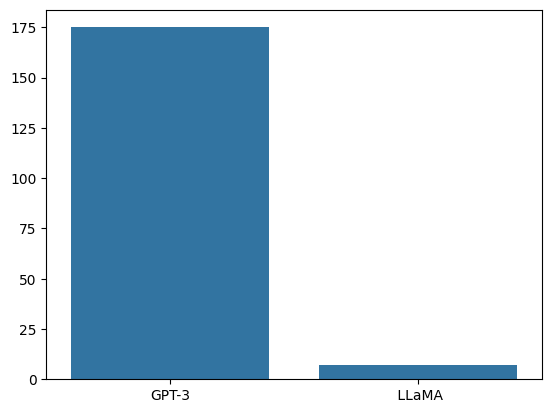

In [46]:
prompt = "Retrieve the number of parameters for GPT-3, LLaMa(largest) and draw a graph"

runnable.invoke(HumanMessage(prompt))